<a href="https://colab.research.google.com/github/rajasarmadishtiaq/VisionTransformer/blob/main/Vision%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Modules needed
# 1. An image converted to patches and vectorized.
# 2. A small ANN with linear layers.
# 3. The positional encoder.
# 4. CLS token.
# 5. MHA and Dense Layer blocks.

In [ ]:
image = Image.open("cat.jpg")
image = image.resize((256, 256))
image = np.array(image)

In [ ]:
image.shape

(256, 256, 3)

In [ ]:
class PatchAndVectorize(nn.Module):
  def __init__(self, image, patch_size):
    super().__init__()
    self.image = image
    self.patch_size = patch_size
    self.width, self.height, self.channels = self.image.shape
    self.patches = []

  def generate_patches(self):
    for h in range(0, self.height, self.patch_size):
      for w in range(0, self.width, self.patch_size):
        patch = self.image[w:w+self.patch_size, h:h+self.patch_size].flatten()
        self.patches.append(patch)

    return self.patches

In [ ]:
patches = PatchAndVectorize(image, 16).generate_patches()

In [ ]:
patches[0].shape

(768,)

In [ ]:
len(patches) # total 256 patches with each patch having shape 16 x 16 x 3 (768)

256

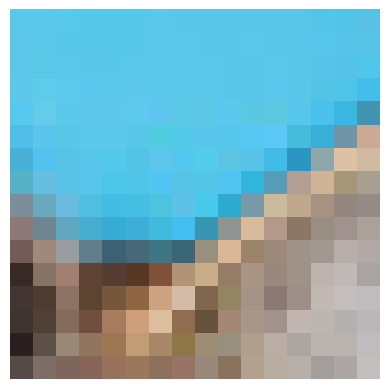

In [ ]:
plt.imshow(patches[180].reshape((16, 16, 3)))
plt.axis('off')
plt.show()

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout_prob=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout_prob)

    position = torch.arange(d_model // 2).unsqueeze(0)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
    pe = torch.zeros(d_model)
    pe[0::2] = torch.sin(position * div_term)
    pe[1::2] = torch.cos(position * div_term)
    self.register_buffer("pe", pe)

  def forward(self, x):
    x = x + self.pe
    return self.dropout(x)

In [ ]:
class HigherDimension(nn.Module):
  def __init__(self, d_model, image, patch_size):
    super().__init__()
    self.pos_encoder = PositionalEncoding(d_model)
    self.patches = PatchAndVectorize(image, patch_size).generate_patches()
    self.dense = nn.Linear(self.patches[0].shape[0], d_model)
    self.z = []
    self.embedding_dim = self.patches[0].shape[0]
    self.cls_token = torch.randn(self.embedding_dim)
    self.embedding = nn.Embedding(num_embeddings=1, embedding_dim=self.embedding_dim)
    self.cls_token_embedding = self.embedding(torch.LongTensor([[0]])).squeeze()

  def generate_z(self):
    for patch in self.patches:
      z = self.dense(torch.tensor(patch).float())
      z = self.pos_encoder(z)
      self.z.append(z)

    self.z.insert(0, self.cls_token_embedding)

    return torch.stack(self.z)


In [ ]:
z = HigherDimension(768, image, 16).generate_z()

In [ ]:
z.shape

torch.Size([257, 768])

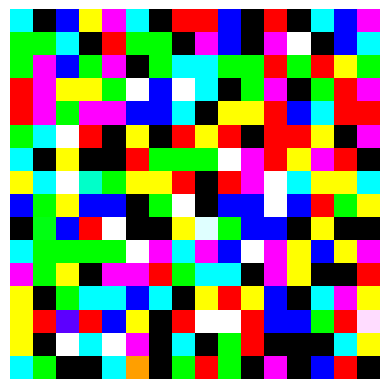

In [ ]:
plt.imshow(z[1].detach().numpy().reshape((16, 16, 3)))
plt.axis('off')
plt.show()

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads, return_attn_weights=False):
    super().__init__()

    self.d_k = d_model // n_heads
    self.d_model = d_model
    self.n_heads = n_heads

    self.query = nn.Linear(d_model, self.d_k*n_heads)
    self.key = nn.Linear(d_model, self.d_k*n_heads)
    self.value = nn.Linear(d_model, self.d_k*n_heads)

    self.fc = nn.Linear(self.d_k * n_heads, d_model)

    self.return_attn_weights = return_attn_weights

  def forward(self, q, k, v):
    q = self.query(q)
    k = self.key(k)
    v = self.value(v)

    attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)

    attn_weights = F.softmax(attn_scores, dim=-1)

    A = attn_weights @ v

    if self.return_attn_weights == True:
      return self.fc(A), A
    else:
      return self.fc(A)


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden_dim)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [ ]:
class VIT(nn.Module):
  def __init__(self, image, n_classes):
    super().__init__()
    self.z = HigherDimension(768, image, 16).generate_z()
    self.MHA = MultiHeadAttention(768, 6, True)
    self.FeedForward = FeedForward(768, 128)
    self.fc = nn.Linear(self.z.shape[1], n_classes)

  def forward(self, epochs, optimizer, criterion, label):
    attentions = []
    for epoch in range(0, epochs):
      x, attn_weights = self.MHA(self.z, self.z, self.z)
      x = self.FeedForward(x)
      x, attn_weights = self.MHA(self.z, self.z, self.z)
      attentions.append(attn_weights)
      x = self.FeedForward(x)

      y = self.fc(x[0])
      y = F.softmax(y, dim=-1)
      prediction = torch.argmax(y)
      print(y, prediction, label)
      loss = criterion(y, label)

      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()

    return x, loss, attentions

In [ ]:
vit = VIT(image, 2)

In [ ]:
optimizer = torch.optim.Adam(vit.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
label = torch.tensor([0.0, 1.0])

In [ ]:
predicted_image, loss, attentions = vit(5, optimizer, criterion, label)

tensor([9.8930e-04, 9.9901e-01], grad_fn=<SoftmaxBackward0>) tensor(1) tensor([0., 1.])
tensor([0.4621, 0.5379], grad_fn=<SoftmaxBackward0>) tensor(1) tensor([0., 1.])
tensor([0.0100, 0.9900], grad_fn=<SoftmaxBackward0>) tensor(1) tensor([0., 1.])
tensor([3.8933e-06, 1.0000e+00], grad_fn=<SoftmaxBackward0>) tensor(1) tensor([0., 1.])
tensor([1.5867e-10, 1.0000e+00], grad_fn=<SoftmaxBackward0>) tensor(1) tensor([0., 1.])


In [ ]:
predicted_image[0].shape

torch.Size([768])

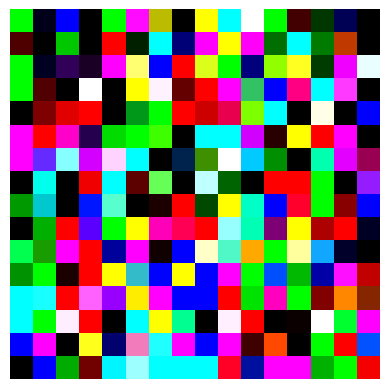

In [ ]:
plt.imshow(predicted_image[180].detach().numpy().reshape((16, 16, 3)))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
attentions[0].shape

torch.Size([257, 768])

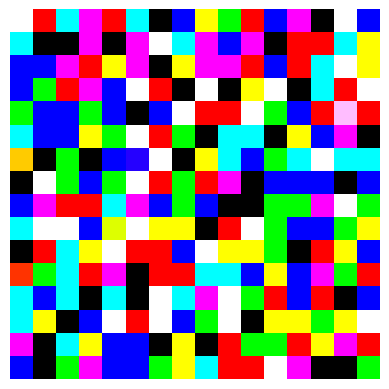

In [ ]:
plt.imshow(attentions[0][190].detach().numpy().reshape((16, 16, 3)))
plt.axis('off')
plt.show()

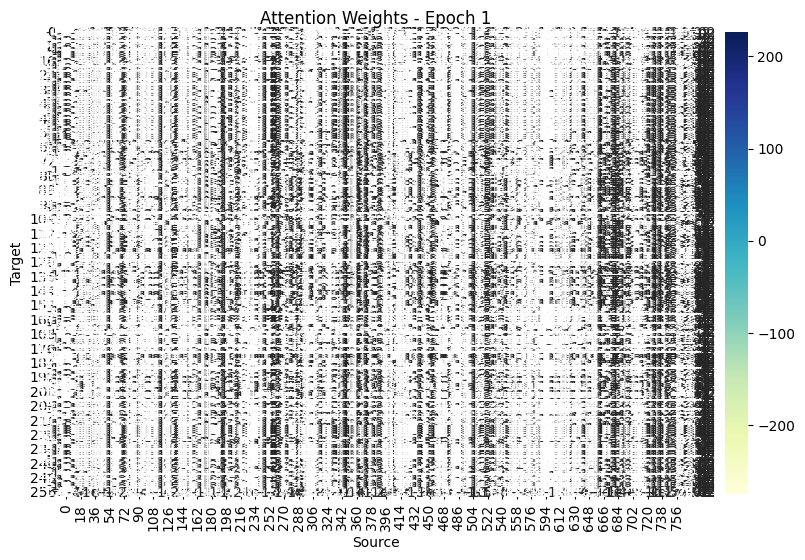

KeyboardInterrupt: 

In [ ]:
import seaborn as sns
def plot_attention_weights(attn_weights):
    for i, weights in enumerate(attn_weights, start=1):
        attn = weights.squeeze(0).cpu().detach().numpy()

        plt.figure(figsize=(10, 6))
        sns.heatmap(attn, annot=True, cmap="YlGnBu", linewidths=.5)
        plt.xlabel("Source")
        plt.ylabel("Target")
        plt.title(f"Attention Weights - Epoch {i}")
        plt.show()

plot_attention_weights(attentions)